In [2]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from chord_recognition.cache import HDF5Cache
from chord_recognition.cnn import deep_auditory_v2
from chord_recognition.dataset import ChromaDataset, prepare_datasource, balanced_datasource, undersample_dataset
from chord_recognition.utils import Rescale, preprocess_spectrogram
from chord_recognition.train import get_weighted_random_sampler, Solver

torch.manual_seed(2020)
RANDOM_STATE = 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Exp1
# datasource = prepare_datasource(('queen', 'beatles', 'robbie_williams', 'zweieck'))
# Exp2
# datasource = balanced_datasource
model = deep_auditory_v2()

In [3]:
# Exp3
# Balance datasets separately and concat them into single dataset.

# Balance beatles dataset
ds = prepare_datasource(('beatles',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

sampling_strategy = {
    0: 8000,
    2: 8000,
    4: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    11: 8000,
    24: 8000,
}
beatles_X, beatles_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Balance robbie_williams dataset
ds = prepare_datasource(('robbie_williams',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

sampling_strategy = {
    0: 8000,
    2: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    24: 5000,
}
robbie_williams_X, robbie_williams_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Balance queen dataset
ds = prepare_datasource(('queen',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

sampling_strategy = {
    2: 4500,
}
queen_X, queen_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Get zweieck data
ds = prepare_datasource(('zweieck',))
dataset = ChromaDataset(
    ds, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'))

zweieck_X = [xi for xi, _ in dataset]
zweieck_y = [yi for _, yi in dataset]

In [4]:
# Concat all datasets
dataset = itertools.chain(
    zip(beatles_X, beatles_y),
    zip(robbie_williams_X, robbie_williams_y),
    zip(beatles_X, beatles_y),
    zip(queen_X, queen_y),
    zip(zweieck_X, zweieck_y),
)

In [5]:
# Split dataset into train/val keeping equal proportions of the each class
# Now train and val datasets have equal class probability distributions.
ds1, ds2 = itertools.tee(dataset)
X = [s for s, _ in ds1]
targets = [t for _, t in ds2]
indices = np.arange(len(X))
X_train, X_val, y_train, y_val, _, _ = train_test_split(
    X, targets, indices, test_size=0.2, stratify=targets, random_state=RANDOM_STATE)

# Cleanup memory
#del beatles_X, beatles_y, robbie_williams_X, robbie_williams_y, beatles_X, beatles_y, queen_X, queen_y
#del zweieck_X, zweieck_y

In [40]:
# Calculate TRAIN_MEAN, TRAIN_STD
#
# Uncomment, calculate and paste values to utils.py
#
#X_train = np.hstack([sample.squeeze(0) for sample in X_train])
#TRAIN_MEAN = X_train.mean(axis=1)
#TRAIN_MEAN
#TRAIN_STD = X_train.std(axis=1)
#TRAIN_STD
#i, j = next(dataset)
#len(X_train), len(X_val)

In [6]:
# Balance the classes in each batch which hopefully helps the training.
sampler = get_weighted_random_sampler(targets, y_train)
# del X, targets, X_train, y_train

In [7]:
len(X_train), len(X_val)

(357066, 89267)

In [8]:
batch_size = 512

# Split dataset into train/val datasets
# Make sure that train and val datasets have equal class probability distributions.
loader_train = DataLoader(
    dataset=[(preprocess_spectrogram(i), t) for i, t in zip(X_train, y_train)],
    batch_size=batch_size,
    sampler=sampler,
    pin_memory=True,
    num_workers=0)
loader_val = DataLoader(
    dataset=[(preprocess_spectrogram(i), t) for i, t in zip(X_val, y_val)],
    num_workers=0,
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

In [39]:
learning_rate = 1e-3
epochs=128
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    learning_rate=learning_rate,
    epochs=epochs)
solver.train()

tensor(3.2086, grad_fn=<NllLossBackward>)


AttributeError: 'int' object has no attribute 'float'

In [14]:
from sklearn.metrics import confusion_matrix

from chord_recognition.utils import one_hot
from chord_recognition.ann_utils import convert_annotation_matrix
from chord_recognition.evaluate import plot_confusion_matrix
from chord_recognition.predict import forward

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = deep_auditory_v2(pretrained=True)
model.eval()
model.cuda()

DeepAuditoryV2(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3a_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_5a_12x9): FactChroma(
    (branch12x9_1): Ba

In [16]:
#val_loader = DataLoader(X_val, batch_size=32)
val_loader = (i for i,_ in loader_val)
y_hat_matrix = forward(model, val_loader, device, 25)

In [19]:
y_hat_matrix = y_hat_matrix.cpu().data.numpy()

[[3119    0    7    2    4   21    1   19    2    5   11    1    1    0
     2    0    5    6    0    3    0    4    0    3    2]
 [   0 1489    1    5    0    0    3    0   15    1    2   10    0    0
     0    1    0    2    4    0    9    0    1    0    2]
 [  18    0 3141    0   10    1    1   11    0   19    3    3    2    0
     2    0    8    0    1    0    0    6    2    9    8]
 [   1    7    0 2081    0    6    1    0   23    0   23    0    0    0
     1    0    1    3    0    1    0    0    1    0    4]
 [   0    1    1    0 2635    0    1    7    0   21    0   16    0    4
     1    0    1    0    2    0    1    4    0    6    5]
 [  26    3    0   10    2 2999    0   12    2    2   24    0    0    0
    15    0    2    3    0    1    0    3    2    1   20]
 [   1    7    0    0    2    0 1127    0    4    1    1    7    0    1
     0    5    0    0    1    0    3    0    1    1    0]
 [  32    0   20    1    4   16    0 2977    5   11    1    1   10    0
     5    0    2  

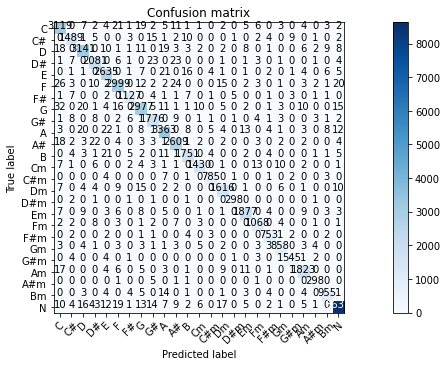

In [20]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 80

y_matrix = one_hot(y_val, 25)
y_true = convert_annotation_matrix(y_matrix)

y_pred = convert_annotation_matrix(y_hat_matrix)
labels = dataset.chord_labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

plot_confusion_matrix(cm, labels)

In [ ]:
# Eliminate overfitting:
# - Try CNN -> CTC loss https://www.cs.toronto.edu/~graves/icml_2006.pdf
# - try CNN for extraction a sequence of features and vanilla RNN to propagate information through this sequence.